### Loading and importing reqired libraries

In [1]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=1140a354eb9035eba6345d024e99ea8fbe758d836ce484580103a55c560daa62
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import re
import string
import warnings
from google.colab import drive
from sentence_transformers import SentenceTransformer, models

In [3]:
warnings.filterwarnings(action='ignore')
drive.mount('/content/drive')

Mounted at /content/drive


#### Data reading

In [4]:
data_path = '/content/drive/MyDrive/MLID/lab2_oil_gas_field_construction_data.csv'
data = pd.read_csv(data_path, sep=',')
data.head(5)

,work_name,generalized_work_class,global_work_class,upper_works
0,монтаж ограждения основания блоков управления са,NaN,NaN,NaN
1,монтаж стоек,NaN,NaN,"('Подготовка свай', 'Монтаж ограждения')"
2,монтаж трубопровода г16/1 газ с предохранитель...,NaN,NaN,NaN
3,монтад лестниц,Монтаж лестниц,Строительство зданий,NaN
4,монтаж площадок,NaN,NaN,NaN


In [5]:
data.shape

(716067, 4)

## Data preprocessing

In [6]:
def cleaning(text):
    text = str(text)
    text = re.sub('\W+', ' ', text)
    text = re.sub('[0-9]+', '', text)
    text = re.split('\W+', text.lower().strip())
    text = ' '.join(text)
    return text

In [7]:
data = data.drop('upper_works', axis=1)
data.head()

,work_name,generalized_work_class,global_work_class
0,монтаж ограждения основания блоков управления са,NaN,NaN
1,монтаж стоек,NaN,NaN
2,монтаж трубопровода г16/1 газ с предохранитель...,NaN,NaN
3,монтад лестниц,Монтаж лестниц,Строительство зданий
4,монтаж площадок,NaN,NaN


In [8]:
data_cleaned = data[~data['generalized_work_class'].isna()]

data_cleaned['generalized_work_class'] = data_cleaned.apply(lambda x: x['generalized_work_class'].lower(), axis=1)
data_cleaned['global_work_class'] = data_cleaned.apply(lambda x: x['global_work_class'].lower(), axis=1)
data_cleaned['work_name'] = data_cleaned.apply(lambda x: cleaning(x['work_name']), axis=1)
print(data_cleaned.shape)
data_cleaned.head()

(296858, 3)


,work_name,generalized_work_class,global_work_class
3,монтад лестниц,монтаж лестниц,строительство зданий
7,кипиа,монтаж приборов,монтаж
9,электромонтажные работы,пнр,пнр
10,погружение свай св хх,погружение свай,монтаж свай
12,монтаж системы вк,испытания системы водоснабжения,испытания систем


In [9]:
data_cleaned.describe()

,work_name,generalized_work_class,global_work_class
count,296858,296858,296858
unique,8496,207,56
top,пнр,монтаж мк,монтаж
freq,7498,26081,38286


In [10]:
gen_class_count = dict(data_cleaned.groupby(['generalized_work_class'])['work_name'].count())
len(gen_class_count)
percentage_ration = []
for k, value in gen_class_count.items():
    percentage_ration.append(value / 296858)

<Axes: title={'center': 'Generalized work classes distrib'}, xlabel='global_work_class'>

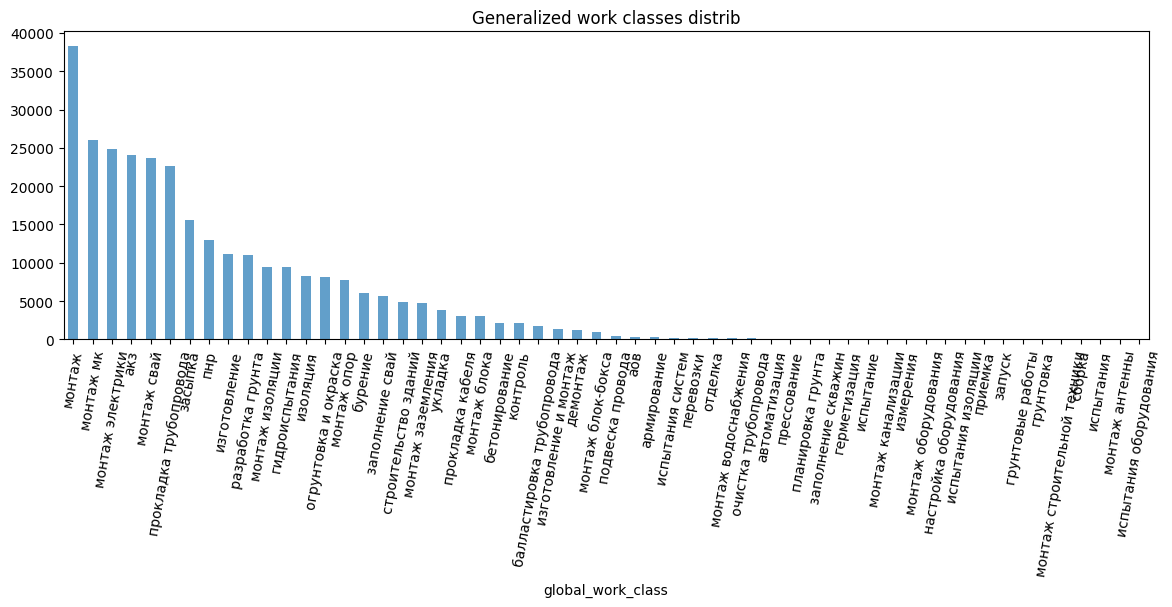

In [23]:
data_cleaned.groupby(['global_work_class'])['generalized_work_class'].count().sort_values(ascending=False).plot(kind='bar', title='Generalized work classes distrib', alpha=0.7, rot=80, figsize=(14, 4))

<Axes: title={'center': 'Work names distrib over gen classes'}, xlabel='generalized_work_class'>

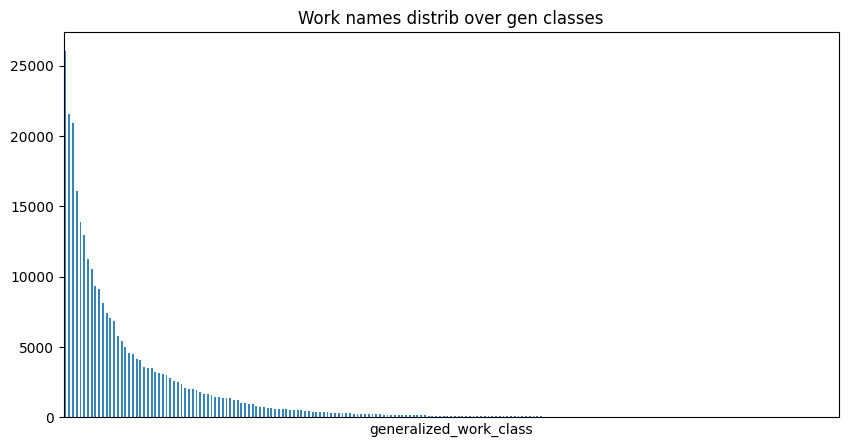

In [28]:
data_cleaned.groupby(['generalized_work_class'])['work_name'].count().sort_values(ascending=False).plot(kind='bar', title='Work names distrib over gen classes', alpha=0.9, xticks=(()), figsize=(10, 5))

In [11]:
grouped_classes = data_cleaned.groupby(['global_work_class', 'generalized_work_class']).count().reset_index()
grouped_classes.head()

,global_work_class,generalized_work_class,work_name
0,автоматизация,"автоматизация, монтаж",113
1,акз,акз мк,586
2,акз,акз резервуара,269
3,акз,акз свай,13918
4,акз,акз трубопровода,9154


### Creating a dictonary of classes after grouping dataset

In [12]:
levels_of_classes = dict()
checked_global_list = list()
for gl_class in grouped_classes['global_work_class']:
    if gl_class not in checked_global_list:
        checked_global_list.append(gl_class)
        levels_of_classes[gl_class] = []
    else:
        continue

for _, row in grouped_classes.iterrows():
     if row[0] in levels_of_classes:
        levels_of_classes[row[0]].append(row[1])

In [13]:
unique_gen_wcs = grouped_classes['generalized_work_class'].unique()
gen_wc_dict = dict()
for i in range(len(unique_gen_wcs)):
    gen_wc_dict[unique_gen_wcs[i]] = i

#### Encoding generalized classes and adding "gen_class_number" column to dataframe

In [14]:
data_cleaned['gen_class_number'] = np.nan
for i, row in data_cleaned.iterrows():
    if row[1] in gen_wc_dict:
        data_cleaned.loc[i, 'gen_class_number'] = gen_wc_dict[row[1]]
    else:
        continue
data_cleaned = data_cleaned.astype({'gen_class_number': 'int32'})
data_cleaned = data_cleaned.reset_index(drop=True)
data_cleaned.head()

,work_name,generalized_work_class,global_work_class,gen_class_number
0,монтад лестниц,монтаж лестниц,строительство зданий,199
1,кипиа,монтаж приборов,монтаж,111
2,электромонтажные работы,пнр,пнр,183
3,погружение свай св хх,погружение свай,монтаж свай,163
4,монтаж системы вк,испытания системы водоснабжения,испытания систем,68


In [15]:
data_cleaned.shape

(296858, 4)

#### Loading Sentence Transformer for creating embeddings

In [16]:
# convert work_name values to embeddings using Sentence_transformer
st_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

#### Creating embedding vectors from work_name column

In [129]:
# embedding creation for all work_name data
# emb_list = dict()
# for i, row in data_cleaned.iterrows():
#     # print(row[0]])
#     emb_list[i] = st_model.encode(row[0])

In [28]:
embedded_data = pd.read_csv('/content/drive/MyDrive/MLID/embedded_data.csv', sep=',')
embedded_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,0,0.071182,0.197128,0.082059,0.063891,-0.091491,-0.182179,0.057702,0.034144,0.035815,...,0.104686,-0.072735,-0.135007,-0.126293,-0.386220,0.136189,0.098293,-0.036498,-0.197582,0.153771
1,1,0.047013,0.088974,-0.061285,0.146593,-0.238069,-0.164214,0.272324,-0.002262,0.101028,...,-0.061570,0.167238,-0.039617,-0.021556,-0.024768,0.228291,0.245154,-0.064740,-0.189073,-0.007262
2,2,-0.224141,0.243768,0.068885,0.203597,-0.016816,-0.219062,0.117978,0.196989,-0.113666,...,0.346883,-0.233348,0.157892,-0.147630,-0.255075,-0.045544,-0.058661,0.037874,-0.068256,0.106691
3,3,0.233802,0.202814,0.018672,-0.059883,-0.228187,-0.168935,0.431788,0.045955,0.040049,...,0.068281,-0.083138,-0.009920,-0.026071,-0.224821,0.146287,0.254510,-0.019191,0.075890,-0.047298
4,4,-0.184490,-0.075917,-0.078500,-0.221787,-0.193483,-0.125991,-0.351943,-0.064178,0.024403,...,0.181737,0.080765,-0.005072,-0.217448,0.048332,0.311513,-0.129434,-0.063626,0.071249,-0.072731


In [29]:
embedded_data = embedded_data.drop('Unnamed: 0', axis=1)
print(embedded_data.shape)
embedded_data.head()

(296858, 384)


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.071182,0.197128,0.082059,0.063891,-0.091491,-0.182179,0.057702,0.034144,0.035815,0.092933,...,0.104686,-0.072735,-0.135007,-0.126293,-0.386220,0.136189,0.098293,-0.036498,-0.197582,0.153771
1,0.047013,0.088974,-0.061285,0.146593,-0.238069,-0.164214,0.272324,-0.002262,0.101028,-0.009746,...,-0.061570,0.167238,-0.039617,-0.021556,-0.024768,0.228291,0.245154,-0.064740,-0.189073,-0.007262
2,-0.224141,0.243768,0.068885,0.203597,-0.016816,-0.219062,0.117978,0.196989,-0.113666,-0.046909,...,0.346883,-0.233348,0.157892,-0.147630,-0.255075,-0.045544,-0.058661,0.037874,-0.068256,0.106691
3,0.233802,0.202814,0.018672,-0.059883,-0.228187,-0.168935,0.431788,0.045955,0.040049,0.064881,...,0.068281,-0.083138,-0.009920,-0.026071,-0.224821,0.146287,0.254510,-0.019191,0.075890,-0.047298
4,-0.184490,-0.075917,-0.078500,-0.221787,-0.193483,-0.125991,-0.351943,-0.064178,0.024403,0.104237,...,0.181737,0.080765,-0.005072,-0.217448,0.048332,0.311513,-0.129434,-0.063626,0.071249,-0.072731


### Train and validation data preparation

In [30]:
features_data = embedded_data.to_numpy()
target_classes = data_cleaned['gen_class_number'].to_numpy()

print(f'features_data shape: {np.shape(features_data)}')
print(f'target_classes shape: {np.shape(target_classes)}')

features_data shape: (296858, 384)
target_classes shape: (296858,)


In [31]:
X_train, X_val, y_train, y_val = train_test_split(features_data,
                                                  target_classes,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True)
print(f'X train shape: {X_train.shape}, \nX val shape: {X_val.shape},\ny train shape: {y_train.shape}\ny val shape: {y_val.shape}')

X train shape: (237486, 384), 
X val shape: (59372, 384),
y train shape: (237486,)
y val shape: (59372,)


In [32]:
!pip install tensorflow

### Model initialization and training

In [33]:
# MLP model initialization and required libs importing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
# from keras.utils.np_utils import to_categorical

batch_size = 128

model = Sequential()
model.add(Dense(512, input_dim=384, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(207, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               197120    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 207)               106191    
                                                                 
Total params: 1353423 (5.16 MB)
Trainable params: 1353423 (5.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'], loss_weights=percentage_ration)

In [36]:
model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
1856/1856 [==============================] - 16s 5ms/step - loss: 1.5180e-04 - sparse_categorical_accuracy: 0.9144
Epoch 2/10
1856/1856 [==============================] - 8s 4ms/step - loss: 2.8094e-05 - sparse_categorical_accuracy: 0.9826
Epoch 3/10
1856/1856 [==============================] - 9s 5ms/step - loss: 1.7605e-05 - sparse_categorical_accuracy: 0.9886
Epoch 4/10
1856/1856 [==============================] - 8s 4ms/step - loss: 1.2684e-05 - sparse_categorical_accuracy: 0.9916
Epoch 5/10
1856/1856 [==============================] - 9s 5ms/step - loss: 9.4408e-06 - sparse_categorical_accuracy: 0.9935
Epoch 6/10
1856/1856 [==============================] - 8s 4ms/step - loss: 7.6809e-06 - sparse_categorical_accuracy: 0.9946
Epoch 7/10
1856/1856 [==============================] - 9s 5ms/step - loss: 6.4260e-06 - sparse_categorical_accuracy: 0.9954
Epoch 8/10
1856/1856 [==============================] - 7s 4ms/step - loss: 5.3616e-06 - sparse_categorical_accuracy: 0.9961

In [37]:
loss, acc = model.evaluate(X_val, y_val, verbose=1)
print(f'Model loss: {round(loss * 100, 2)}, Accuracy: {round(acc * 100, 2)}')

1856/1856 [==============================] - 6s 3ms/step - loss: 1.3394e-05 - sparse_categorical_accuracy: 0.9943
Model loss: 0.0, Accuracy: 99.43


### Model predictions on validation data

In [38]:
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis = 1)[:]
for i in range(5):
    print('Predicted generalized_work_class --> ', list(gen_wc_dict.keys())[list(gen_wc_dict.values()).index(predictions[i])])
    print('Actual generalized_work_class --> ', list(gen_wc_dict.keys())[list(gen_wc_dict.values()).index(y_val[i])])
    print('\n')

1856/1856 [==============================] - 4s 2ms/step
Predicted generalized_work_class -->  монтаж теплоизоляции
Actual generalized_work_class -->  монтаж теплоизоляции


Predicted generalized_work_class -->  пнр
Actual generalized_work_class -->  пнр


Predicted generalized_work_class -->  монтаж потолка
Actual generalized_work_class -->  монтаж потолка


Predicted generalized_work_class -->  погружение свай
Actual generalized_work_class -->  погружение свай


Predicted generalized_work_class -->  обратная засыпка
Actual generalized_work_class -->  обратная засыпка




### Test data loading and preparing

In [39]:
test_data_path = '/content/drive/MyDrive/MLID/lab2_test_dataset.csv'
test_data = pd.read_csv(test_data_path, sep=';')
print(test_data.shape)
test_data.head()

(197906, 4)


,index,work_name,generalized_work_class,global_work_class
0,507695.0,"монтаж шаровых кранов, дроссельной шайбы, запо...",Монтаж мк,Монтаж мк
1,464317.0,монтаж кипиа и зра с электроприводом,Монтаж ЗРА,Монтаж
2,43108.0,монтаж оборудования и приборов,Монтаж приборов,Монтаж
3,114289.0,тх./поз.2.13.1-2/монтаж арматуры,Монтаж арматуры,Монтаж
4,331380.0,"монтаж шаровых кранов, огнепреградителя, дросс...",Монтаж мк,Монтаж мк


In [40]:
test_data_cleaned = test_data

test_data_cleaned['generalized_work_class'] = test_data_cleaned.apply(lambda x: cleaning(x['generalized_work_class']), axis=1)
test_data_cleaned['global_work_class'] = test_data_cleaned.apply(lambda x: cleaning(x['global_work_class']), axis=1)
test_data_cleaned['work_name'] = test_data_cleaned.apply(lambda x: cleaning(x['work_name']), axis=1)
test_data_cleaned = test_data_cleaned.drop('index', axis=1)
test_data_cleaned.head()

,work_name,generalized_work_class,global_work_class
0,монтаж шаровых кранов дроссельной шайбы запорн...,монтаж мк,монтаж мк
1,монтаж кипиа и зра с электроприводом,монтаж зра,монтаж
2,монтаж оборудования и приборов,монтаж приборов,монтаж
3,тх поз монтаж арматуры,монтаж арматуры,монтаж
4,монтаж шаровых кранов огнепреградителя дроссел...,монтаж мк,монтаж мк


In [41]:
test_data_cleaned['gen_class_number'] = np.nan
for i, row in test_data_cleaned.iterrows():
    if row[1] in gen_wc_dict:
        test_data_cleaned.loc[i, 'gen_class_number'] = gen_wc_dict[row[1]]
    else:
        continue
test_data_cleaned = test_data_cleaned[~test_data_cleaned['gen_class_number'].isna()]
test_data_cleaned = test_data_cleaned.astype({'gen_class_number': 'int32'})
test_data_cleaned = test_data_cleaned.reset_index(drop=True)
test_data_cleaned.head()

,work_name,generalized_work_class,global_work_class,gen_class_number
0,монтаж шаровых кранов дроссельной шайбы запорн...,монтаж мк,монтаж мк,152
1,монтаж кипиа и зра с электроприводом,монтаж зра,монтаж,95
2,монтаж оборудования и приборов,монтаж приборов,монтаж,111
3,тх поз монтаж арматуры,монтаж арматуры,монтаж,75
4,монтаж шаровых кранов огнепреградителя дроссел...,монтаж мк,монтаж мк,152


In [50]:
# emb_test_list = dict()
# for i, row in data_cleaned.iterrows():
#     emb_test_list[i] = st_model.encode(row[0])

In [ ]:
# embedded_test_data = pd.DataFrame.from_dict(emb_test_list, orient='index')
# embedded_test_data.to_csv('/content/drive/MyDrive/MLID/embedded_test_data.csv')

### Loading processed test data

In [42]:
import json

In [43]:
embedded_test_data_path = '/content/drive/MyDrive/MLID/test_data.json'

with open(embedded_test_data_path, 'r') as j:
     contents = json.loads(j.read())


In [44]:
embedded_test_data = np.array(contents)
embedded_test_data.shape

(195080, 384)

In [45]:
test_targets_classes = test_data_cleaned['gen_class_number'].to_numpy()
test_glob_targets_classes = np.array(test_data_cleaned['global_work_class'])
print(test_targets_classes.shape)
len(test_glob_targets_classes)

(195080,)


195080

### Model predictions and estimation on test data

In [47]:
predictions_on_test = model.predict(embedded_test_data)
predictions_on_test = np.argmax(predictions_on_test, axis = 1)[:]


6097/6097 [==============================] - 12s 2ms/step


In [48]:
for i in range(0, 10000, 1000):
    gen_class_pred = list(gen_wc_dict.keys())[list(gen_wc_dict.values()).index(predictions_on_test[i])]
    actual_gen_class = list(gen_wc_dict.keys())[list(gen_wc_dict.values()).index(test_targets_classes[i])]
    glob_class_associate = ''
    actual_glob_class = test_glob_targets_classes[i]
    for k, value_list in levels_of_classes.items():
        if gen_class_pred in value_list:
            glob_class_associate = k

    print('Predicted generalized_work_class --> ', gen_class_pred, end=' ')
    print('--> Actual generalized_work_class --> ',actual_gen_class)
    print('Associated global_work_class --> ', glob_class_associate, end=' ')
    print('--> Actual global_work_class --> ', glob_class_associate)
    print('\n')

Predicted generalized_work_class -->  монтаж мк --> Actual generalized_work_class -->  монтаж мк
Associated global_work_class -->  монтаж мк --> Actual global_work_class -->  монтаж мк


Predicted generalized_work_class -->  сварка трубопровода --> Actual generalized_work_class -->  сварка трубопровода
Associated global_work_class -->  прокладка трубопровода --> Actual global_work_class -->  прокладка трубопровода


Predicted generalized_work_class -->  монтаж теплоизоляции --> Actual generalized_work_class -->  монтаж теплоизоляции
Associated global_work_class -->  монтаж изоляции --> Actual global_work_class -->  монтаж изоляции


Predicted generalized_work_class -->  окраска поверхностей трубопроводов --> Actual generalized_work_class -->  окраска поверхностей трубопроводов
Associated global_work_class -->  огрунтовка и окраска --> Actual global_work_class -->  огрунтовка и окраска


Predicted generalized_work_class -->  обратная засыпка --> Actual generalized_work_class -->  обратн

### Metrics calculation

In [50]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, balanced_accuracy_score

f1 = f1_score(test_targets_classes, predictions_on_test, average='micro')
accuracy = accuracy_score(test_targets_classes, predictions_on_test)
bal_acc = balanced_accuracy_score(test_targets_classes, predictions_on_test)
recall = recall_score(test_targets_classes, predictions_on_test, average='micro')
precision = precision_score(test_targets_classes, predictions_on_test, average='micro')
print(f'F1 score: {round(f1, 4)},\nAccuracy: {round(accuracy, 4)}, \nBalanced Accuracy: {round(bal_acc, 4)}')
print(f'Recall: {round(recall, 4)},\nPrecision: {round(precision, 4)}')

F1 score: 0.9949,
Accuracy: 0.9949, 
Balanced Accuracy: 0.9505
Recall: 0.9949,
Precision: 0.9949
